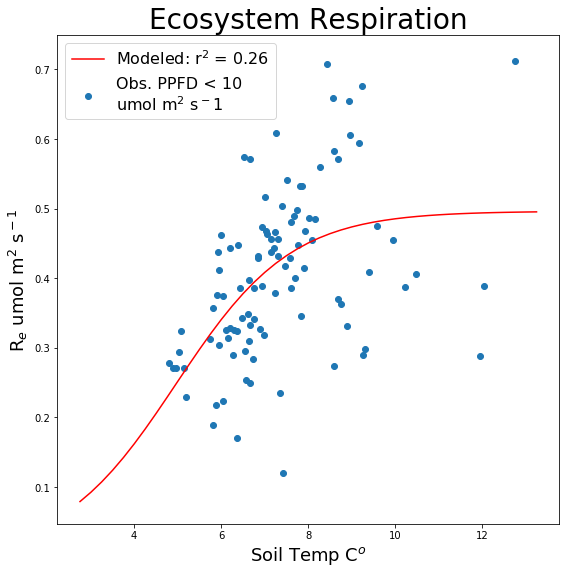

0.3788005015254207 0.04073538328979746
0.2595913502350178
0.10317807818717176


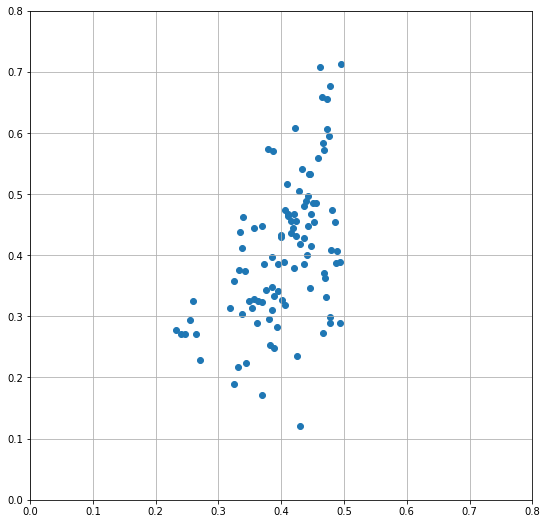

In [3]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
from sklearn.utils import resample
%matplotlib inline
from matplotlib.ticker import NullFormatter

from scipy.optimize import curve_fit

from sklearn import metrics
import Data_Processor as DP
import importlib
importlib.reload(DP)

Root = 'C:/Illisarvik/'

Flux_Path = Root+'Flux_Results/eddypro_Illisarvik_full_output_2017-03-08T142621.csv'
BL_Path = Root+'SlowMet/BL_Data.csv'
Met_Path = Root+'SlowMet/CR1000_Table1.DAT'
Soil_Path = Root+'SoilSensors/SoilData.txt'

Comp = DP.Compile(Flux_Path,BL_Path,Met_Path,Soil_Path)


Comp.Rain_Check([0,0])

Comp.Wind_Bins(30)
    
Comp.QC_Check(2)
Comp.Spike_Removal(z_thresh=4)
Comp.StorageCorrection()
Comp.Wind_Filter(30)
# Comp.ustar_Bins(15,{'Var':'PPFD_Avg','Thresh':10},{'Var':'ch4_flux','Plot':True},
#                 {'Repetitions':100,'n_samples':10000})
Comp.Ustar_Drop()

Data = Comp.Data.copy()
Data['Temp'] = (Data['Temp1']+Data['Temp2'])/2
Data['VWC'] = (Data['VWC1']+Data['VWC2'])/2
Data.loc[Data['VWC']<=.4] = np.nan
Data.to_csv(Root+'FilteredData' +str(dt.datetime.now()).split(' ')[0]+'.csv')
# plt.plot(Data['VWC'])#.resample('D').mean())

# import sys
# # sys.path.append('C:/Users/wesle/Dropbox/Hacks')
# # import PltHacks as PH
# import numpy as np
# import pandas as pd
# from matplotlib import pyplot as plt
# # import datetime as dt
# from scipy import stats
# from sklearn import metrics


def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def P_func(PPFD,MQY,PM):
    cv =.7
    return(MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5/(2*cv))
def Line(X,m,b):
    return(m*X+b)




Data['fco2']=Data['fco2']*1e-6 * 44.0095 *3600
Dark_Thresh = 10
Dark = Data[(Data['PPFD_Avg']<=Dark_Thresh)&(Data['fco2']>=0)]
Dark = Dark[['fco2','PPFD_Avg','Temp','u*','VWC']].dropna()
# plt.plot(Dark['fco2'])

# print(Dark['fco2'].count())

popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 4.59262144,0.5875255,0.27508822))
Data['R'] = Data['fco2']
Data.loc[Data['PPFD_Avg']>10,['R']]=np.nan
Data['R'] = Data['R'].fillna(R_func(Data['Temp'],*popt_r))
Data['GPP'] = (Data['R']-Data['fco2'])
P = Data[Data['PPFD_Avg']>=Dark_Thresh]
P = P[['GPP','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], P['GPP'],p0=(.003,12))
Data['GPP'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
Data['GPP_fill'] = P_func(Data['PPFD_Avg'],*popt_p)
## Ordered Data for Plotting fits
Temp = np.arange(Data['Temp'].min(),Data['Temp'].max(),.25)
PAR = np.arange(Data['PPFD_Avg'].min(),Data['PPFD_Avg'].max(),1)

## Calculate r2
Rsq_Resp = metrics.explained_variance_score(Dark['fco2'].values,R_func(Dark['Temp'],*popt_r))
Rsq_GPP = metrics.explained_variance_score(P['GPP'].values,P_func(P['PPFD_Avg'],*popt_p))

fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize = (9,9))
axes.scatter(Dark['Temp'],Dark['fco2'],label = 'Obs. PPFD < '+str(Dark_Thresh)+'\numol m$^2$ s$^-1$')
axes.plot(Temp,R_func(Temp,*popt_r),color = 'red',label = 'Modeled: r$^2$ = '+str(np.round(Rsq_Resp,2)))
axes.legend(loc = 2,fontsize = 16)
axes.set_ylabel('R$_e$ umol m$^2$ s$^-$$^1$',fontsize = 18)
axes.set_xlabel('Soil Temp C$^o$',fontsize = 18)
axes.set_title('Ecosystem Respiration',fontsize = 28)
plt.show()
PRed =R_func(Temp,*popt_r)
print(np.mean(PRed),np.std(PRed)/(PRed.shape[0]**.5)*1.96)#,Dark['fco2'].sem()*1.96)

Dark = Data.loc[Data['PPFD_Avg']<10,['PPFD_Avg','Temp','fco2']].dropna()
fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize = (9,9))
axes.scatter(R_func(Dark['Temp'],*popt_r),Dark['fco2'],
             label = 'Obs. PPFD < '+str(Dark_Thresh)+'\numol m$^2$ s$^-1$')
axes.grid()
plt.xlim(0,.8)
plt.ylim(0,.8)


print(metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)))
print(metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5)
# axes.plot(Temp,R_func(Temp,*popt_r),color = 'red',label = 'Modeled: r$^2$ = '+str(np.round(Rsq_Resp,2)))
# axes.legend(loc = 2,fontsize = 16)
# axes.set_ylabel('R$_e$ umol m$^2$ s$^-$$^1$',fontsize = 18)
# axes.set_xlabel('Soil Temp C$^o$',fontsize = 18)
# axes.set_title('Ecosystem Respiration',fontsize = 28)

# We'll Incoroporate the chamber data here!!!

In [4]:


Area = np.asanyarray([0.021764,0.378160,0.367951,0.105923,0.124064])
print(Area.sum())

0.9978619999999999


   Unnamed: 0        CI       MSE  \
0           1  0.124966  1.018748   
1           2  0.192334  0.777587   
2           3  0.138154  0.523013   
3           4  0.132971  0.401271   
4           5  0.117030  0.379274   
5           6  0.084744  0.342648   
6           7  0.066946  0.334779   
7           8  0.062881  0.347710   
8           9  0.081541  0.375026   
9          10  0.044536  0.306218   

                                              Models  
0                                     Model: Shrubby  
1                          Model: wind_speed+Shrubby  
2                Model: wind_speed+AirTC_Avg+Shrubby  
3       Model: wind_speed+AirTC_Avg+PPFD_Avg+Shrubby  
4  Model: wind_speed+AirTC_Avg+PPFD_Avg+Shrubby+U...  
5  Model: wind_speed+AirTC_Avg+PPFD_Avg+Temp+Shru...  
6  Model: wind_speed+AirTC_Avg+PPFD_Avg+Temp+Rain...  
7  Model: wind_speed+AirTC_Avg+PPFD_Avg+Temp+Rain...  
8  Model: wind_speed+AirTC_Avg+PPFD_Avg+Temp+Rain...  
9  Model: wind_speed+AirTC_Avg+PPFD_Avg+Te

<module 'matplotlib.pyplot' from 'C:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

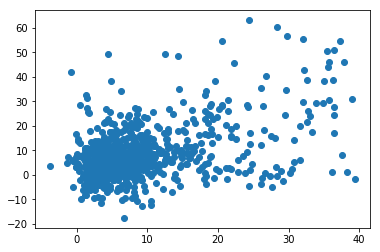

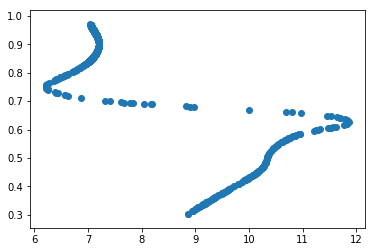

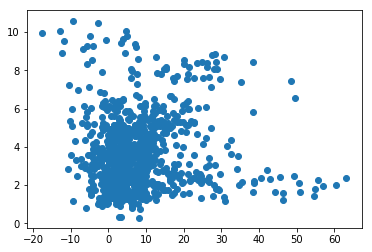

In [111]:
# Data = pd.read_csv('C:\\Users\\wesle\\Illisarvik_Processing/Data_Footprints_2018-05-01.csv')
# # for d in Data:
# #     print(d)
# plt.scatter(Data['Shrubby'],Data['fch4'])

DataPath = 'C:\\Users\\wesle\\Downloads/GapFilledfco2.csv'
DataPath2 = 'C:\\Users\\wesle\\Downloads/GapFilledfch4.csv'


SummaryPath = 'C:\\Users\\wesle\\Downloads/GapFillingSummaryfco2.csv'
SummaryPath2 = 'C:\\Users\\wesle\\Downloads/GapFillingSummaryfch4.csv'

Data = pd.read_csv(DataPath)
Data2 = pd.read_csv(DataPath2)


plt.scatter(Data2['Model: wind_speed+AirTC_Avg+PPFD_Avg+Shrubby'],Data2['fch4'])

Data['Fco2'] = Data['fco2'].fillna(Data['Model: wind_speed+AirTC_Avg+PPFD_Avg+VWC+Shrubby'])
Data['Fch4'] = Data['fch4'].fillna(Data2['Model: wind_speed+AirTC_Avg+PPFD_Avg+Shrubby'])
plt.figure()
# plt.scatter(Data2['Fch4'],Data2['fch4'])

Summary = pd.read_csv(SummaryPath)
Summary2 = pd.read_csv(SummaryPath2)

print(Summary2)
for i,mod in enumerate(Summary2.Models):
    print(i,mod)
# plt.figure()
# plt.bar(Summary2.index,Summary2.MSE)
# plt.figure()
plt.scatter(Data2['Model: Shrubby'],Data['Shrubby'])
# plt.scatter(Data2['Model: wind_speed+Shrubby'],Data['wind_speed'])
plt.figure()
plt.scatter(Data2['fch4'],Data2['wind_speed'])
plt

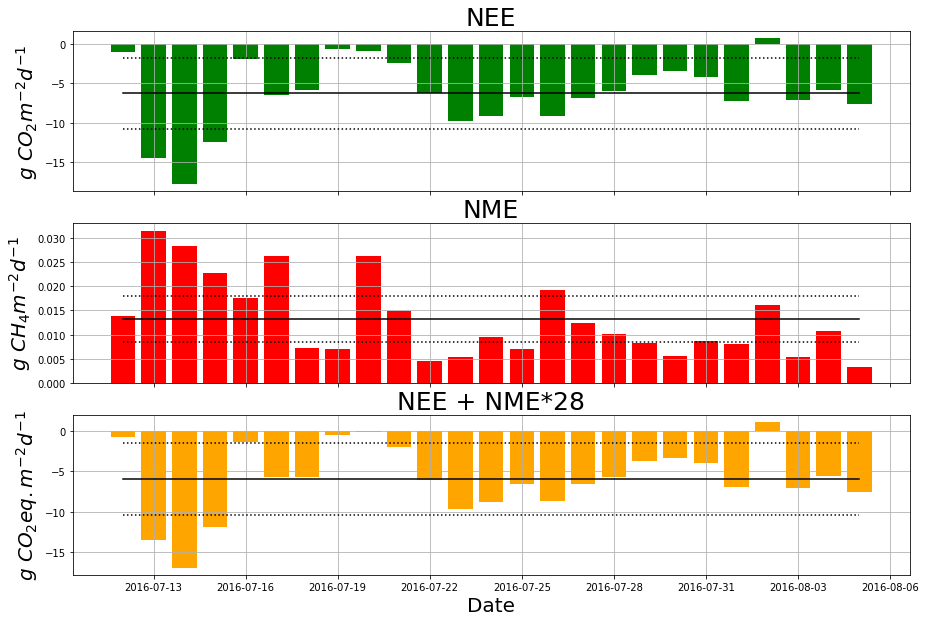

In [105]:

Data['FCH4'] = Data['Fch4'] *1e-6* 16.04246 *3600*24*1e-3
Data['FCO2'] = Data['Fco2'] *1e-6* 44.0095 *3600*24
Data['Bal'] = Data['FCH4']*28+Data['FCO2']
Data['I']=Data.index
Data = Data.set_index(pd.DatetimeIndex(Data.datetime))
Daily = Data.resample('D').mean()
Daily = Daily[1:-1]
Dailystd = Data.resample('D').std()
Daily = Daily[1:-1]
Dailyc = Data.resample('D').count()
# DailyErr = Dailystd/Daily.count
Dailyerr = Dailystd/Daily.count()**.5*1.96
Dailyerr = Dailyerr[1:-1]
Daily.reset_index()
# print(Data['FCH4'])

fig,ax = plt.subplots(3,1,figsize = (15,10),sharex=True)


ax[0].bar(Daily.index,Daily['FCO2'],color='green')
ax[0].plot(Daily.index,Daily['FCO2']*0+Daily['FCO2'].mean(),color = 'black')
ax[0].plot(Daily.index,Daily['FCO2']*0+Daily['FCO2'].mean()+Dailyerr['FCO2'].mean(),color = 'black',linestyle =':')
ax[0].plot(Daily.index,Daily['FCO2']*0+Daily['FCO2'].mean()-Dailyerr['FCO2'].mean(),color = 'black',linestyle =':')

ax[1].bar(Daily.index,Daily['FCH4'],color='red')
ax[1].plot(Daily.index,Daily['FCH4']*0+Daily['FCH4'].mean(),color = 'black')
ax[1].plot(Daily.index,Daily['FCH4']*0+Daily['FCH4'].mean()+Dailyerr['FCH4'].mean(),color = 'black',linestyle =':')
ax[1].plot(Daily.index,Daily['FCH4']*0+Daily['FCH4'].mean()-Dailyerr['FCH4'].mean(),color = 'black',linestyle =':')

ax[2].bar(Daily.index,Daily['Bal'],color='orange')
ax[2].plot(Daily.index,Daily['Bal']*0+Daily['Bal'].mean(),color = 'black')
ax[2].plot(Daily.index,Daily['Bal']*0+Daily['Bal'].mean()+Dailyerr['Bal'].mean(),color = 'black',linestyle =':')
ax[2].plot(Daily.index,Daily['Bal']*0+Daily['Bal'].mean()-Dailyerr['Bal'].mean(),color = 'black',linestyle =':')


ax[0].grid()
ax[1].grid()
ax[2].grid()

ax[0].set_title('NEE',fontsize = 25)
ax[1].set_title('NME',fontsize = 25)
ax[2].set_title('NEE + NME*28',fontsize = 25)

ax[0].set_ylabel('$g\ CO_{2} m^{-2} d^{-1}$',fontsize = 20)
ax[1].set_ylabel('$g\ CH_{4} m^{-2} d^{-1}$',fontsize = 20)
ax[2].set_ylabel('$g\ CO_{2} eq. m^{-2} d^{-1}$',fontsize = 20)
ax[2].set_xlabel('Date',fontsize = 20)
plt.savefig('C:\\Users\\wesle\\FreiburgPres/IllisarvikBallance2png',dpi = 400)

# print(Data)
'$g\ CO_{2} m^{-2} d^{-1}$'
mgCH4 = '$mg\ CH_{4} m^{-2} d^{-1}$'
gCO2eq = '$g\ CO_{2} eq. m^{-2} d^{-1}$'
plt.show()